# Введение 

В данной серии заметок предлагаю поговорить о некоторых типовых задачах компьютерного зрения, связанных с оптическими свойствами камер, геометрией сцен и изображений. Для комфортного восприятия материала будет полезным знакомство с линейной алгеброй, аналитической геометрией и методами оптимизации.

Заметки имеют естественную структуру: каждый раздел посвящен конкретной задаче и включает в себя её формулировку, теоретические сведения и ссылки на дополнителнительные материалы. Т.к. курс предназначен в первую очередь для самостоятельного изучения, каждая тема снабжена набором практических заданий с тестами и решениями. Рекомендую решать задания, добиваясь прохождения тестов, а приложенные решения использовать уже для самопроверки. 

### Системы координат и переход между ними. Однородные координаты

Данная глава является вводной и нужна, чтобы ввести обозначения, которыми мы будем пользоваться, а также немного поупражняться в преобразованиях координат. 


Рассмотрим точку $P$, расположенную в базисе $(W) = (O_W, i, j, k)$ с координатами $\overline{OP} = Xi + Yj + Zk$. Чтобы не терять информацию о выбранном базисе, укажем его слева сверху от координатного вектора, т.е. ${^W}P$ &ndash; координаты точки $P$ в базисе $(W)$. 

В задачах компьютерного зрения приходится постоянно переходить между различными системами координат. Самый распространенный пример: переход от мировой с.к. $W(O_W,i,j,k)$ к с.к. $C(O_C, i, j, k)$, связанной с камерой, и обратно. С точки зрения геометрии для такого преобразования нужно сперва сориентировать координатные оси с направлением камеры, а затем перенести в точку её размещения. 

<img src="../assets/images/axes_transform_2d_projection.svg" alt="Coordinates transform" style="background-color:#d3d3d3"/> 

В общем виде преобразование координат можно описать следующим уравнением 

$^A P = \mathcal{R} \; {^B}P + t \quad \quad \quad \quad(1)$,

где $\mathcal{R}$  матрица поворота, а $t$ &ndash; вектор переноса. 

Выражение (1) имеет простой вид, но работа с ним требует внимательности и аккуратности. На практике прежде чем подставлять матрицы, векторы и точки в уравнение, важно сперва разобраться, в каком базисе должны быть вычислены координаты, а затем проверить, что все элементы согласованы с направлением преобразования. В качестве примера рассмотрим схему ниже. 

Пусть имеется матрица поворота $\mathcal{R}$, переводящая базис $(W)$ в $(C)$ (когда точки $O_W$ и $O_C$ совпадают) и вектор смещения $t = O_C - O_W$. Вопрос: какое из равенств окажется выполнено, если $\mathcal{R}$ и $t$ подставить их в уравнение (1)?

(a) $^W P = \mathcal{R} \; {^C}P + t $ <br />
(b) $^C P = \mathcal{R} \; {^W}P + t $

<img src="../assets/images/axes_transform_bidirection.svg" alt="Coordinates transform" style="background-color:#d3d3d3"/> 

Правильный ответ (a): если знать положение и ориентацию камеры, то уравнение (1) позволит узнать координаты объектов, связанных с базисом камеры $(C)$, в мировых координатах $(W)$. Но чаще требуется решать обратную задачу и пересчитывать мировые координаты объектов в систему координат, связанную с камерой. Чтобы понять, как это сделать, расмотрим один математический приём.  

Поставим вектору $(X,Y,Z)^T \in \mathbb{R}^3$ в соответствие вектор $(X,Y,Z,1)^T \in \mathbb{R}^4$ в однородных координатах. Теперь выражение (1) можно записать в виде одной операции произведения: 

$^A P = \mathcal{T} {^B}P = \begin{pmatrix}
                    \mathcal{R} & t \\
                            0^T & 1
                  \end{pmatrix} {^B} P$

Тогда выражение (a) с нужными базисами будет выглядеть вот так <br />
$^W P = \mathcal{T} {^B}P = \begin{pmatrix}
                    \mathcal{R} & t \\
                            0^T & 1
                    \end{pmatrix} {^C} P$ 

И чтобы пересчитывать мировые координаты объектов в координаты камеры, достаточно достаточно найти обратную матрицу для $\mathcal{T}$:

$^C P = \mathcal{T}^{-1} \; {^W}P = \begin{pmatrix}
                    \mathcal{R^{-1}} & -R^{-1}t \\
                                 0^T & 1
                    \end{pmatrix} {^W} P 
                    = \begin{pmatrix}
                    \mathcal{R}^{T} & -R^{T}t \\
                                0^T & 1
                    \end{pmatrix} {^W} P$ 



Более подробно о математике координат можно почитать в книге Computer Vision a Modern Approach by David A. Forsyth, Jean Ponce, раздел Geometric Camera Models, а мы переходим к практике.

### Задачи на переход между координатными системами

В задачах такого типа самое важное &ndash; научиться различать тип объекта, на который действует преобразование. Если матрица перехода действует не посредственно на векторы базиса, то получается новый базис $B_C = B_W T$. Координаты в этих базисах преобразуются иначе! Возьмем точку с координатами в новом  базисе ${^C}P$ и подставим в уравнение, получится $B_C \; {^C}P =  B_W T \; {^C}P$. Добавив скобки для наглядности можно увидеть интересный факт:  $B_C \; {^C}P =  B_W (T \; {^C}P) = B_W \; {^W}P $, где $B_W (T \; {^C}P) = B_W \; {^W}P$ в силу однозначности координатного представления. 

Т.е. матрица перехода $T$, превращающая базис $W$ в базис $C$, преобразует координаты точек в "обратном" направлении из базиса $C$ в координаты точек в базисе $W$. 

In [1]:
# Вспомогательные функции для визуализации с.к.

import matplotlib.pyplot as plt
import numpy as np

import os 
import sys

# add parent dir to import path 
parent_dir = os.path.abspath('..')
sys.path.append(parent_dir)

import utils.frame_plotter as fp
import utils.scene_elements as se

#### Задание 1
Пусть заданы 2 координатные системы $W(O_W,i,j,k)$ и $C(O_C, i, j, k)$, также точка ${^C}P = (1,2,3)$ (координаты даны в базисе $(C)$!). Координаты т. $O_С$ в базисе $W$: ${^W}O_С = (5,6,7)$, направления осей  у обоих базисов совпадают. Найти матрицу перехода и координаты ${^W}P$.

In [2]:
WO_w = np.array([0,0,0])
WO_c = np.array([5,6,7])

CP = np.array([1,2,3])

T = None
WP = None

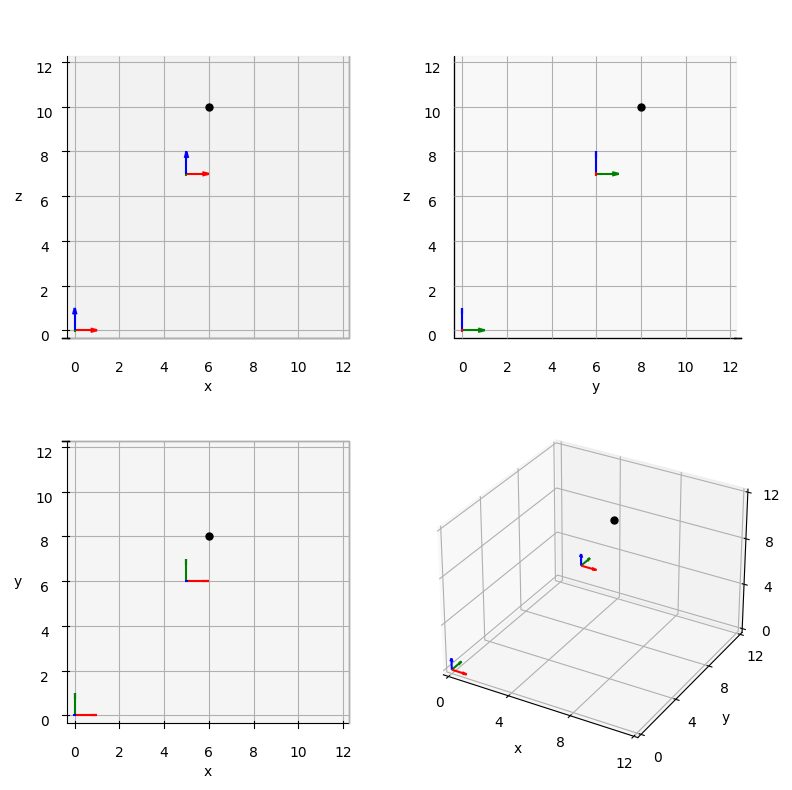

In [3]:
world_basis = se.Basis(
        name='W',
        origin=WO_w,
        basis=np.array([[1,0,0],[0,1,0],[0,0,1]]))

camera_basis = se.Basis(
        name='C', 
        origin=WO_c,
        basis=np.array([[1,0,0],[0,1,0],[0,0,1]]))
        
point = se.Point(
        name='P',
        coords=CP,
        basis=camera_basis)

scene = fp.Scene()
scene.add_element(world_basis)
scene.add_element(camera_basis)
scene.add_element(point)
scene.render()

In [4]:
# Решение
WO_w = np.array([0,0,0])
WO_c = np.array([5,6,7])
CP = np.array([1,2,3])

WP = CP + WO_c # т.к. базисные векторы не меняют направления, 
               # для пересчета координат достаточно учесть смещение 
print(f'решение \n {WP}')

R = np.eye(3)  
t = np.expand_dims(WO_c, axis=1)

WTC = np.hstack((R, t)) # матрица перехода в сокращенной форме (3,4)
print(f'матрица перехода от W к C \n {WTC}')

CP_hom = np.hstack((CP, [1]))
print(f'решение \n {WTC @ CP_hom}') # проверка с помощью перемножения матриц

решение 
 [ 6  8 10]
матрица перехода от W к C 
 [[1. 0. 0. 5.]
 [0. 1. 0. 6.]
 [0. 0. 1. 7.]]
решение 
 [ 6.  8. 10.]


#### Задание 2

Заданы 2 координтные системы $W(O_W,i,j,k)$ и $C(O_C, i, j, k)$. Точка $P$ имеет координаты ${^W}P = (1,2,3)$ (в с.к. W). Начало координат $(C)$ т. $O_c$ в с.к. $W$: ${^W}O_с = (5,6,7)$. Найти координаты ${^C}P$ и матрицу (оператор) перехода.

In [6]:
WO_w = np.array([0,0,0])
WO_c = np.array([5,6,7])

WP = np.array([1,2,3])

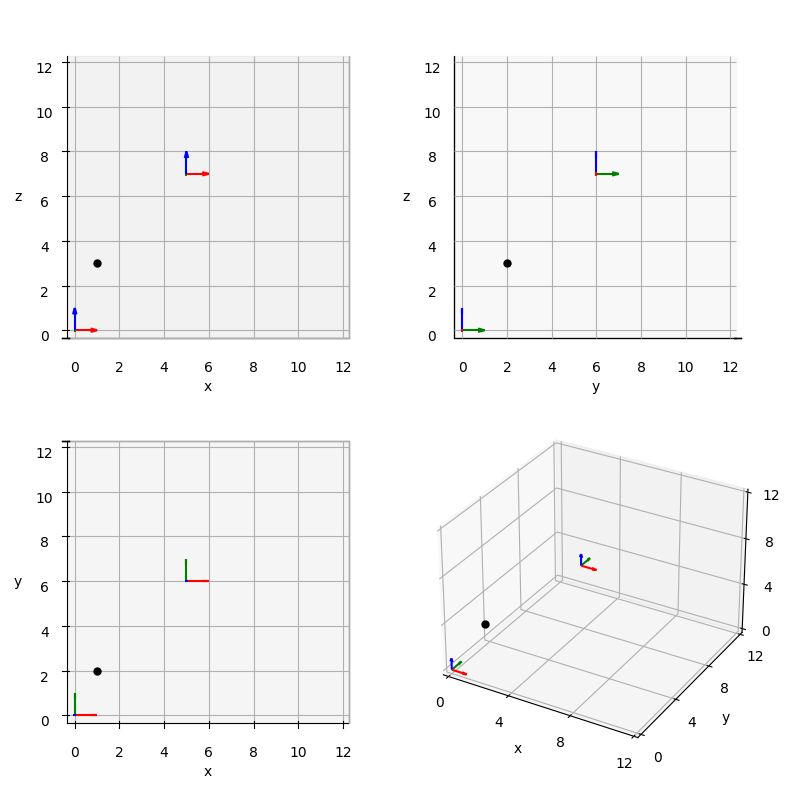

In [7]:
# Визуализация
world_basis = se.Basis(
        name='W',
        origin=WO_w,
        basis=np.array([[1,0,0],[0,1,0],[0,0,1]]))

camera_basis = se.Basis(
        name='C', 
        origin=WO_c,
        basis=np.array([[1,0,0],[0,1,0],[0,0,1]]))
        
point = se.Point(
        name='P',
        coords=WP,
        basis=world_basis) 

scene = fp.Scene()
scene.add_element(world_basis)
scene.add_element(camera_basis)
scene.add_element(point)
scene.render()

In [8]:
# Решение
WO_w = np.array([0,0,0])
WO_c = np.array([5,6,7])

WP = np.array([1,2,3])

# в прошлый задаче матрица сразу обеспечивала преобразование в нужном направлении:
# от базиса камеры к базису мира. Сейчас необходимо выполнить обратное преобразование -
# перевевести точку из мировых координат в координаты камеры. Поэтому сейчас нужно 
# строить обратную матрицу

# сперва построим матрицу преобразования C -> W
t = WO_c - WO_w
R = np.eye(3)
WTC = np.zeros((4,4))
WTC[:3,:3] = R
WTC[:3,3] = t
WTC[3,3] = 1

CTW = np.linalg.inv(WTC) # матрица перехода (4,4)
print(f'матрица перехода от C к W \n {CTW[:3,:]}')

WP_hom = np.hstack((WP, [1]))
CP = (CTW @ WP_hom)[:3]
print(f'решение \n {CP}')



матрица перехода от C к W 
 [[ 1.  0.  0. -5.]
 [ 0.  1.  0. -6.]
 [ 0.  0.  1. -7.]]
решение 
 [-4. -4. -4.]


#### Задание 3

Усложним предыдущую задачу. Точка $P$ по-прежнему имеет координаты ${^W}P = (1,2,3)$ (в с.к. W). Но теперь базис $C$ не только смещен ${^W}O_с = (5,6,7)$, но и повернут, относительно базиса $W$ на $\pi/2$ вокруг вектора $k_W$ (он же ось z). Найти координаты ${^C}P$ и матрицу перехода.

In [2]:
WO_w = np.array([0,0,0])
WO_c = np.array([5,6,7])
WP = np.array([1,2,3])

WR_z = np.array([[0, -1,  0],
                 [1,  0,  0],
                 [0,  0,  1]])



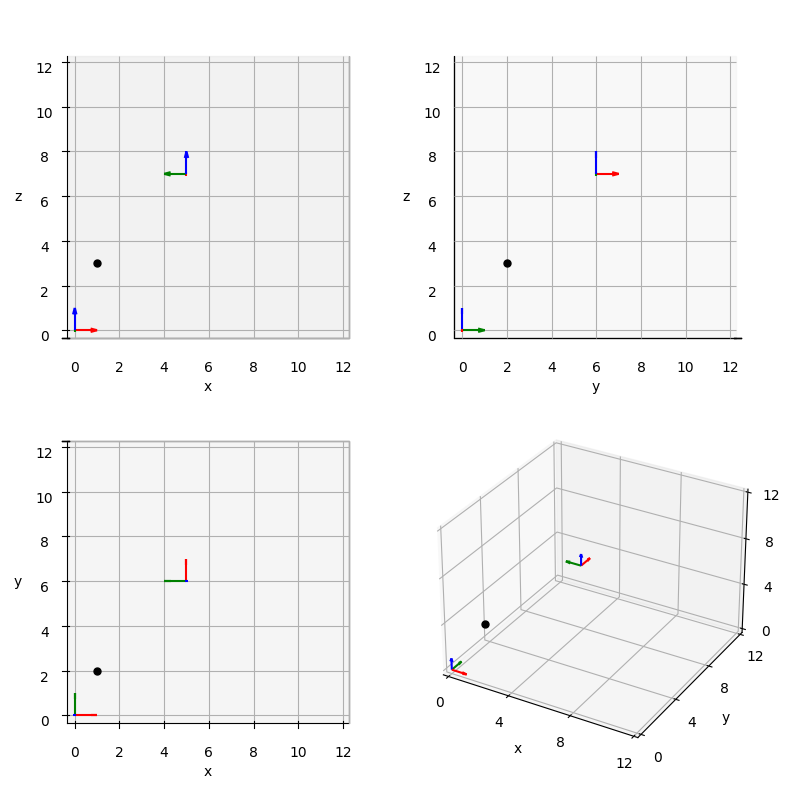

In [4]:
# Визуализация
world_basis = se.Basis(
        name='W',
        origin=WO_w,
        basis=np.eye(3))

camera_basis = se.Basis(
        name='C', 
        origin=WO_c,
        basis=WR_z)
        
point = se.Point(
        name='P',
        coords=WP,
        basis=world_basis) 

scene = fp.Scene()
scene.add_element(world_basis)
scene.add_element(camera_basis)
scene.add_element(point)
scene.render()

In [5]:
# решение

WO_w = np.array([0,0,0])
WO_c = np.array([5,6,7])

WR_z = np.array([[0, -1,  0],
                 [1,  0,  0],
                 [0,  0,  1]])

WP = np.array([1,2,3])

t = WO_c - WO_w

WTC = np.zeros((4,4))
WTC[:3,:3] = WR_z
WTC[:3,3] = t
WTC[3,3] = 1

CTW = np.linalg.inv(WTC) 
print(f'матрица перехода от C к W \n {CTW[:3,:]}')

WP_hom = np.hstack((WP, [1]))
CP = (CTW @ WP_hom)[:3]
print(f'решение \n {CP}')

матрица перехода от C к W 
 [[ 0.  1.  0. -6.]
 [-1. -0. -0.  5.]
 [ 0.  0.  1. -7.]]
решение 
 [-4.  4. -4.]


#### Задание 4

Рассматрим как работать с композицией поворотов. Точка $P$ имеет координаты ${^W}P = (1,2,3)$ (в с.к. W). Базис $C$ на смещен ${^W}O_с = (5,6,7)$, и повернут на $\pi/2$ относительно вектора $i_W$ (ось x) и на $-\pi/4$ относительно вектора $k_W$ (ось z)

In [8]:
from numpy import cos, sin
WO_w = np.array([0,0,0])
WO_c = np.array([5,6,7])

WR_i = np.array([[1,  0,  0],
                 [0,  0, -1],
                 [0,  1,  0]])

WR_k = np.array([[ cos(np.pi/4),  sin(np.pi/4),  0],
                 [-sin(np.pi/4),  cos(np.pi/4),  0],
                 [           0,             0,  1]])

WP = np.array([1,2,3])
WR = None # последовательность применения поворотов важна

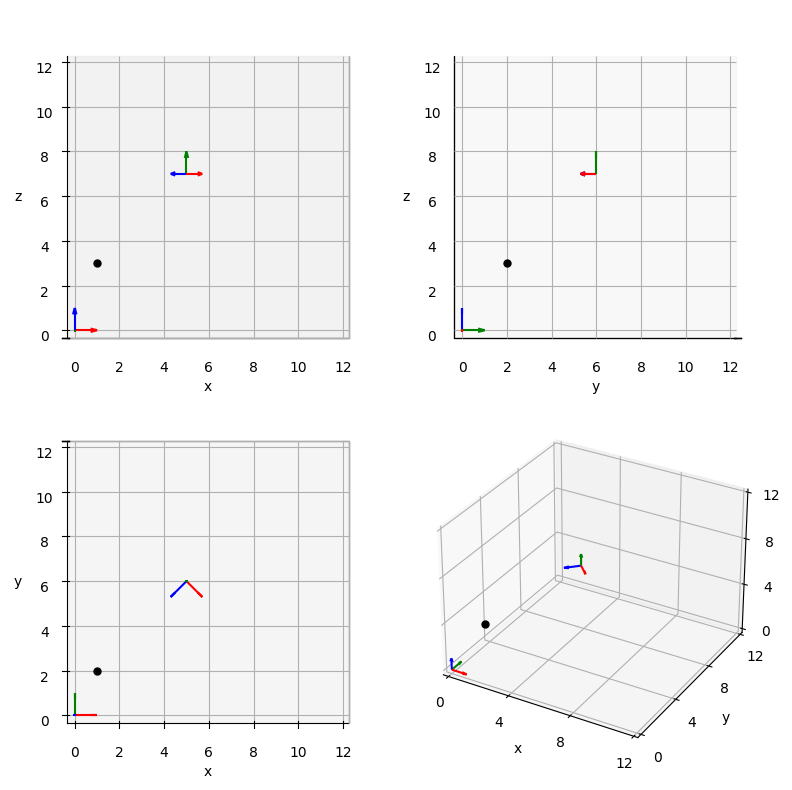

In [10]:
# Визуализация
world_basis = se.Basis(
        name='W',
        origin=WO_w,
        basis=np.array([[1,0,0],[0,1,0],[0,0,1]]))

camera_basis = se.Basis(
        name='C', 
        origin=WO_c,
        basis= WR_k @ WR_i)
        
point = se.Point(
        name='P',
        coords=WP,
        basis=world_basis) 

scene = fp.Scene()
scene.add_element(world_basis)
scene.add_element(camera_basis)
scene.add_element(point)
scene.render()

In [11]:
# решение
from numpy import cos, sin
np.set_printoptions(precision=4, suppress=True)

WO_w = np.array([0,0,0])
WO_c = np.array([5,6,7])

WR_i = np.array([[1,  0,  0],
                 [0,  0, -1],
                 [0,  1,  0]])

WR_k = np.array([[ cos(np.pi/4),  sin(np.pi/4),  0],
                 [-sin(np.pi/4),  cos(np.pi/4),  0],
                 [           0,             0,  1]])

WP = np.array([1,2,3])
WR = WR_k @ WR_i # последовательность применения поворотов важна
print(f'полная матрица поворота \n {WR}')

t = WO_c - WO_w

WTC = np.zeros((4,4))
WTC[:3,:3] = WR
WTC[:3,3] = t
WTC[3,3] = 1

CTW = np.linalg.inv(WTC) 
print(f'матрица перехода от C к W \n {CTW[:3,:]}')

WP_hom = np.hstack((WP, [1]))
CP = (CTW @ WP_hom)[:3]
print(f'решение \n {CP}')

полная матрица поворота 
 [[ 0.7071  0.     -0.7071]
 [-0.7071  0.     -0.7071]
 [ 0.      1.      0.    ]]
матрица перехода от C к W 
 [[ 0.7071 -0.7071  0.      0.7071]
 [ 0.      0.      1.     -7.    ]
 [-0.7071 -0.7071 -0.      7.7782]]
решение 
 [ 0.     -4.      5.6569]
